In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/126565347.gadi-pbs'

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### load data sets

In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [5]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [43, 44]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')


print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0043.nc']
51.91852368 G
32.01238728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho
correctly mask melt


In [6]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPA/' # Truth file settings
prefix='roms_avg_'
timeRange = [43, 44]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_MKPA = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0043.nc']
51.91852368 G
32.01238728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [7]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPB/' # Truth file settings
prefix='roms_avg_'
timeRange = [43, 44]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


ds_MKPB = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPB/roms_avg_0043.nc']
51.91852368 G
32.01238728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho
correctly mask melt


In [8]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r


In [9]:
# now load lima

import rioxarray

lima_full = rioxarray.open_rasterio('../data/raw/lima/00000-20080319-092059124.tif')

lima = lima_full.where((lima_full.x>1.68e6)&(lima_full.x<2.5e6)&(lima_full.y>.4e6)&(lima_full.y<1e6),drop=True)


### finished preliminary loading data

In [10]:
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds.ocean_time.isel(ocean_time=winter_period)[0].values,' to ',ds.ocean_time.isel(ocean_time=winter_period)[-1].values)
print(ds.ocean_time.isel(ocean_time=summer_period)[0].values,' to ',ds.ocean_time.isel(ocean_time=summer_period)[-1].values)

2049-09-04T12:00:00.000000000  to  2049-11-03T12:00:00.000000000
2049-03-03T12:00:00.000000000  to  2049-05-02T12:00:00.000000000


Text(0.5, 1.0, 'Winter salinity difference (No-Mackenzie - CTRL; +ve is increased salinity)')

<Figure size 640x480 with 0 Axes>

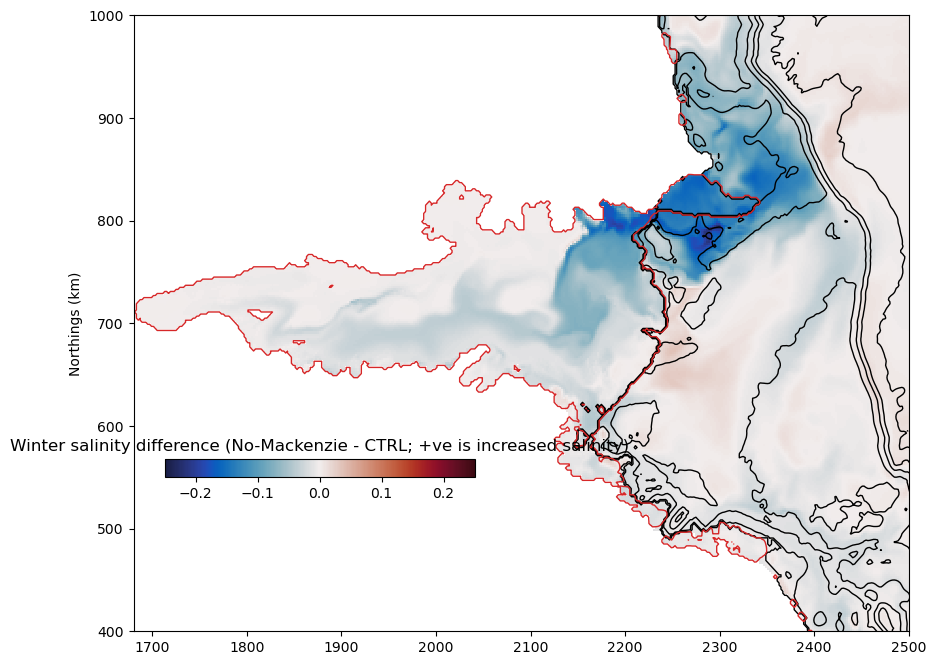

In [11]:
# test plot salt in SDW period

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
diff_plot = (ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) - (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None

ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Winter salinity difference (No-Mackenzie - CTRL; +ve is increased salinity)')


# annotations


Text(0.5, 1.0, 'Bottom salinity')

<Figure size 640x480 with 0 Axes>

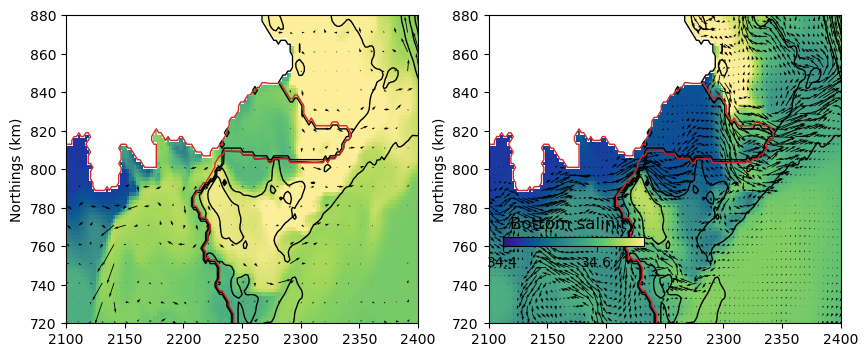

In [12]:

# us_rho_sum   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# vs_rho_sum   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# us_rho_win   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
# vs_rho_win   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# diff_plot = (ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) - (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,4])
ax = None

ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=34.4,vmax=34.7,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)


# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((2.1e6,2.4e6))
ax.set_ylim((.72e6,.88e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')



ax=fig.add_subplot(gs[0,1])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',vmin=34.4,vmax=34.7,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::2,0::2], grd.y_rho.values[0::2,0::2], uvel2[0::2,0::2], vvel2[0::2,0::2],scale=2,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((2.1e6,2.4e6))
ax.set_ylim((.72e6,0.88e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Bottom salinity')


# annotations


<Figure size 640x480 with 0 Axes>

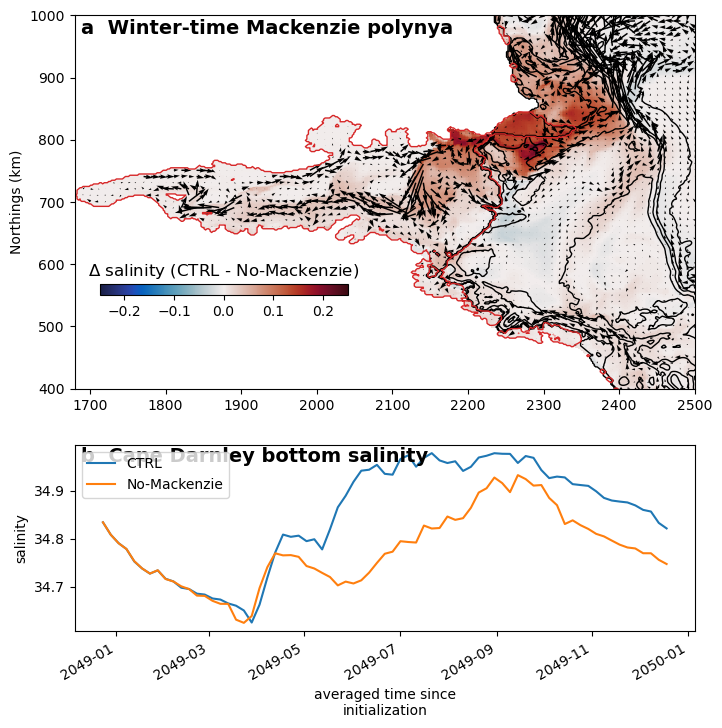

In [13]:
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
diff_plot = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2,height_ratios=[2,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None

ax=fig.add_subplot(gs[0,0])
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)


ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, 'a  Winter-time Mackenzie polynya', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

# cax = inset_axes(ax,
#                 width="40%",  # width = 10% of parent_bbox width
#                 height="3%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(.04,.1, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
# cax.set_title(r'annual-mean melt rate (m/yr)')



cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (CTRL - No-Mackenzie)')


# annotations


ax=fig.add_subplot(gs[1,0])
(ds_CTRL.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPA.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=True)



Text(0, 0.5, 'melt rate (m/yr)')

<Figure size 640x480 with 0 Axes>

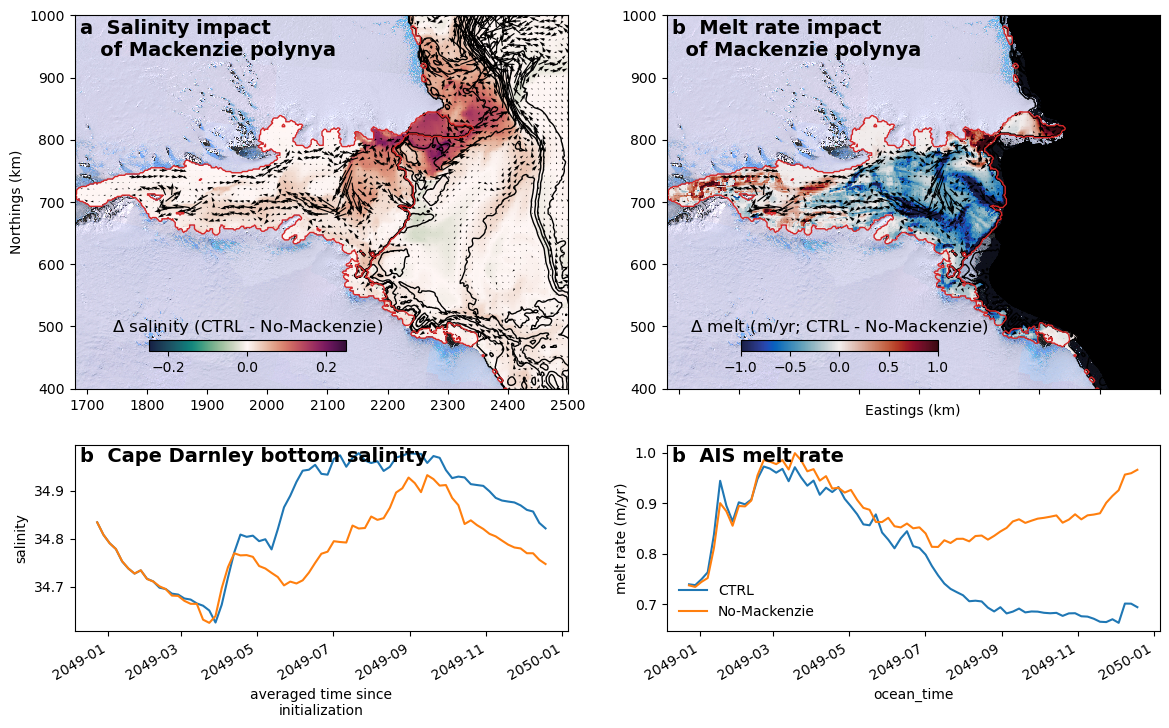

In [14]:
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
diff_plot = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

diff_plot2 = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.my.isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.my.isel(ocean_time=winter_period).mean(dim='ocean_time'))



gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.2, hspace=0.2,height_ratios=[2,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None

#####################################

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.curl',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, """a  Salinity impact
   of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (CTRL - No-Mackenzie)')




#####################################

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot2.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-1,vmax=1,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, """b  Melt rate impact
  of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ melt (m/yr; CTRL - No-Mackenzie)')


# annotations


ax=fig.add_subplot(gs[1,0])
(ds_CTRL.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPA.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
# ax.legend(frameon=True)



ax=fig.add_subplot(gs[1,1])
(ds_CTRL.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPA.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  AIS melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=False,loc='lower left')
ax.set_ylabel('melt rate (m/yr)')


#### MKPB

Text(0, 0.5, 'melt rate (m/yr)')

<Figure size 640x480 with 0 Axes>

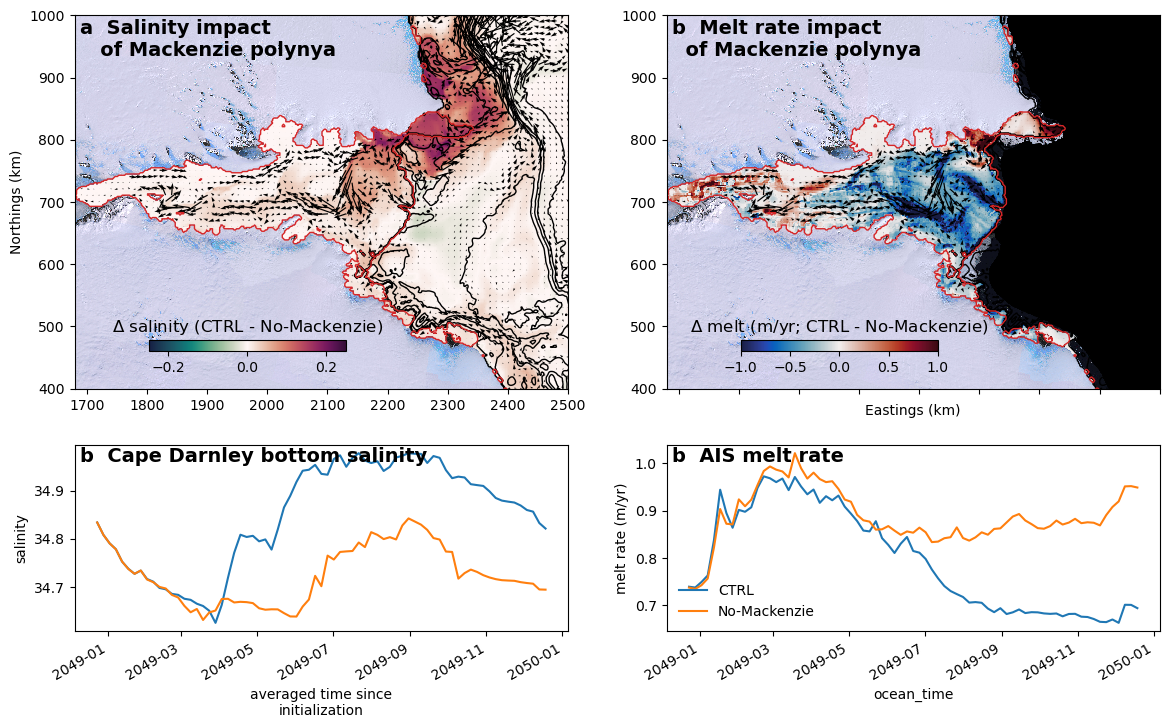

In [15]:
ub_rho_ctrl   = ds_CTRL.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_ctrl   = ds_CTRL.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_mkpa   = ds_MKPA.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_mkpa   = ds_MKPA.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
diff_plot = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPB.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time'))

diff_plot2 = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPB.my.isel(ocean_time=winter_period).mean(dim='ocean_time')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.my.isel(ocean_time=winter_period).mean(dim='ocean_time'))



gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.2, hspace=0.2,height_ratios=[2,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None

#####################################

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.curl',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, """a  Salinity impact
   of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (CTRL - No-Mackenzie)')




#####################################

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot2.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-1,vmax=1,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_title('')

ax.text(0.01, 0.99, """b  Melt rate impact
  of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ melt (m/yr; CTRL - No-Mackenzie)')


# annotations


ax=fig.add_subplot(gs[1,0])
(ds_CTRL.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPB.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440)).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  Cape Darnley bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
# ax.legend(frameon=True)



ax=fig.add_subplot(gs[1,1])
(ds_CTRL.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5,label='CTRL')
(ds_MKPB.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5,label='No-Mackenzie')
ax.text(0.01, 0.99, 'b  AIS melt rate', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_title('')
ax.legend(frameon=False,loc='lower left')
ax.set_ylabel('melt rate (m/yr)')


In [16]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# test plot salt in SDW period

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.035, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,6])
ax = None

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  Mar$-$May', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



############## Now panel b

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('')
ax.text(0.01, 0.99, 'b  Sep$-$Nov', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom salinity')




ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



In [ ]:

# us_rho_sum   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# vs_rho_sum   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
# us_rho_win   = ds.u_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
# vs_rho_win   = ds.v_rho.isel(s_rho=-1).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
ub_rho_sum   = ds.u_rho.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
vb_rho_sum   = ds.v_rho.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time').values   
ub_rho_win   = ds.u_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   
vb_rho_win   = ds.v_rho.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time').values   

uvel1=ub_rho_sum
vvel1=vb_rho_sum
uvel2=ub_rho_win
vvel2=vb_rho_win


# test plot salt in SDW period

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.035, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,6])
ax = None

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  Mar$-$May', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



############## Now panel b

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('')
ax.text(0.01, 0.99, 'b  Sep$-$Nov', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom salinity')




ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)





In [ ]:
# test plot salt in SDW period

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.05,height_ratios=[2.5,1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  Mar$-$May', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=summer_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)



############## Now panel b

ax=fig.add_subplot(gs[0,1])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt.isel(s_rho=0).isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
                                                                                                                      vmin=34.3,vmax=34.9,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho*(ds.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('')
ax.text(0.01, 0.99, 'b  Sep$-$Nov', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,.00, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Mean bottom salinity')




ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="25%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.02, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
im1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',add_colorbar=False,
                                                                                                       vmin=-4,vmax=4)
co1 = (ds.mask_rho*(ds.mask_ziceNaN)*ds.my.isel(ocean_time=winter_period).mean(dim='ocean_time')).plot.contour(ax=ax,x='x_rho',y='y_rho',colors='k',linewidths=1,
                                                                                                         levels=np.arange(-4,6,2))
# co2 = (-ds.zice*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k')
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.set_xlim((1.68e6,2.25e6))
ax.set_ylim((.55e6,.85e6))
# ax.set_ylabel('Northings (km)',fontsize=20)
# ax.set_xlabel('Eastings (km)',fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="100%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.01,0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='vertical') 
cax.set_ylabel(r'melt rate (m/yr)')#,fontsize=14)
# cbar.ax.tick_params(labelsize=14)


########### make two quick time series plots


ax=fig.add_subplot(gs[1,0])
(ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',
                                                                                                               linewidth=1.5)

ax=fig.add_subplot(gs[1,1])
ds.salt.isel(s_rho=0).isel(xi_rho=390,eta_rho=440).plot(color='C1',linewidth=1.5)


In [ ]:
STOP

In [ ]:
# # make 400m transects
# target_depth = -400

# target_time = slice(5,18)
# temp400_FM = grid.transform(ds.temp.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # ur400_FM = grid.transform(ds.u_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # vr400_FM = grid.transform(ds.v_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()




# target_time = slice(55,67)
# temp400_ON = grid.transform(ds.temp.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_ON = grid.transform(ds.salt.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # ur400_ON = grid.transform(ds.u_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # vr400_ON = grid.transform(ds.v_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()


In [ ]:
import seawater as sw
sw.temp(35,-2,1000)

In [ ]:
aa=-5.73e-2
bb=9.39e-2
cc=-7.61e-4


Tb_FM = ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
Sb_FM = ds.salt.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')

Tf = aa*Sb_FM + bb + cc*-ds.zice


Tb_insitu = sw.temp(Sb_FM,Tb_FM,-ds.z_rho0.isel(s_rho=-1).values)

Tstar = (Tb_insitu-Tf)*ds.mask_zice_nan


In [ ]:
uvel=ds.u_rho.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vvel=ds.v_rho.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}
ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.5,levels=12)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))
plt.show()

Tstar.plot.pcolormesh(x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.5,vmax=.5)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))

plt.show()

st = plt.pcolormesh(ds.x_rho.values, ds.y_rho.values, vel_mag,)
st = plt.quiver(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,scale=15,minshaft = 1, minlength=0)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))

plt.show()


# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# temp400_ON.plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-.5,levels=12)
# st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
# co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
# plt.xlim((2.2e6,2.47e6))
# plt.ylim((.4e6,1.0e6))

In [ ]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(6,4))

ax=fig.add_subplot(gs[0,0])
ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.8,levels=12)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.225e6))
plt.ylim((.73e6,.825e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  surface temp (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')

ax=fig.add_subplot(gs[1,0])
Tstar.plot.pcolormesh(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.4,vmax=.4)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.225e6))
plt.ylim((.73e6,.825e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
ax.text(0.01, 0.99, 'b  $T^*$ (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
ax.set_title('')



In [ ]:
ds.temp.isel(s_rho=-1,ocean_time=0).plot()
plt.axis((300,500,350,450))
plt.show()
ds.temp.isel(s_rho=-1,eta_rho=395,xi_rho=350).plot()
plt.show()
plt.plot(ds.salt.isel(s_rho=-1,eta_rho=395,xi_rho=350),'.')


In [ ]:



gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,6])
ax = None


ax=fig.add_subplot(gs[0,0])
# im = ds.temp.isel(s_rho=-2).isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.5,vmax=.5,levels=12)
im=Tstar.plot.pcolormesh(x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.5,vmax=.5,add_colorbar=False)
# st = plt.quiver(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,scale=15,minshaft = 1, minlength=0)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((1.65e6,2.3e6,.6e6,.84e6))

# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.text(0.01, 0.99, 'T$^*$ ($^\circ$C)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')

ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'Thermal driving ($^\circ$C)')




# # convert polarstereo to lat/lon and vice versa.
# from pyproj import Transformer
# from pyproj import CRS
# ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
# ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# arr_start_ps=(2.2125e6,0.45e6)
# arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
# print(arr_start_ps)
# arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
# print(arr_end)
# ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
#     xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
#     color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
# ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# # uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# # vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# # vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# # str_kwargs = {"color":vel_mag.values,
# #               "linewidth":1,
# #               "arrowsize":1,
# #               "density":8,
# #               "cmap":"pink"}
# ax=fig.add_subplot(gs[0,1])
# im = ds.temp.isel(s_rho=-2).isel(ocean_time=slice(270,330)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.5,vmax=.5,levels=12)
# ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=2.5)

# # st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# # po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
# co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
# co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
# ax.set_xlim((2.2e6,2.6e6))
# ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.text(0.01, 0.99, 'b  surface temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.grid()
# scale_ticks = 1e3
# ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.xaxis.set_major_formatter(ticks_x)
# ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
# ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# ax.set_title('')










In [ ]:
STOP

In [ ]:
uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5

str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":5,
              "cmap":"pink"}


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(6,8))
ax=fig.add_subplot(gs[0,1])
ds.temp.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
# ax.set_xlabel('')
ax.text(0.01, 0.99, 'c  surface temp\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
ax.set_title('')



In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None

ax=fig.add_subplot(gs[0,0])
#change to 400m
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))

ax=fig.add_subplot(gs[1,0])
#change to 400m
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[0,1])
#change to 400m
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))

ax=fig.add_subplot(gs[1,1])
#change to 400m
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))





In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,0])
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  400m\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xticklabels([])
ax.set_title('')


# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

arr_start_ps=(1.75e6,.625e6)
arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
print(arr_start_ps)
arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
print(arr_end)
ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,1])
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  400m temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="175%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'potential temperature ($^\circ$C)')



ax=fig.add_subplot(gs[1,0])
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.text(0.01, 0.99, 'c  400m salt\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xticklabels([])
ax.set_ylabel('Northings (km)')
# ax.set_xlabel('')
ax.set_xlabel('Eastings (km)')


ax=fig.add_subplot(gs[1,1])
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.text(0.01, 0.99, 'd 400m salt\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ax.set_ylabel('Depth (m)')
ax.set_xlabel('Eastings (km)')
ax.set_yticklabels([])

cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'salinity')








In [ ]:
# ds.mke.isel(s_rho=-2).plot(cmap='inferno')

In [ ]:
# ds.eke.isel(s_rho=-2).mean(dim='ocean_time').plot(cmap='cividis')